# img2svg - Development notebook

## Setup

Recommended to use a virtual environment (mamba can be replaced with conda):

```bash

    # create environment
    mamba create -n img2svg python=3

    # activate environment
    mamba activate img2svg

    # install useful packages
    mamba install requests pillow numpy scikit-image matplotlib tqdm opencv-python ipykernel numba
    pip install opencv-python

    # for intel cpu (faster numba)
    mamba install intel-cmplr-lib-rt
```

In [23]:
from functools import cache
from io import BytesIO

import cv2
import matplotlib.pyplot as plt
from numba import float64 as nf64
from numba import jit as njit
import numpy as np
import requests
import time
from PIL import Image
from scipy.optimize import minimize
from tqdm import tqdm
import pandas as pd

## Load an image

In [24]:
local_path = "Test Images/1.png"
img = cv2.imread(local_path)

In [25]:
# convert to lab color space
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

In [26]:
# resize
dim = 512
img_resized = cv2.resize(lab, (dim, dim))

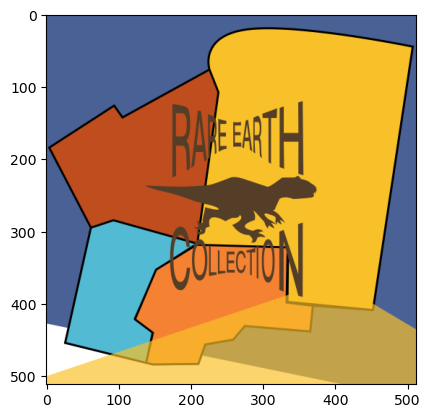

In [27]:
# display
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_LAB2RGB))

In [28]:
img_resized.min(), img_resized.max()

(np.uint8(0), np.uint8(255))

In [29]:
# convert to float between 0 and 1
img_np = img_resized / 255.0

In [30]:
img_np.shape, img_np.dtype, img_np.min(), img_np.max()

((512, 512, 3), dtype('float64'), np.float64(0.0), np.float64(1.0))

## Preprocess - TODO later

Suggested steps:

- Optional steps per paper, section 3.3.10

  - downsample
  - non-linear de-noising filter to remove easy-to-detect noise
  - Note: may be applicable more to scanned images

- Normalize size (based on largest side)

- Leverage Craiyon to flatten the image

## Segmentation

In [31]:
@njit(fastmath=True)
def initPixelSegmentation(P):
    assert P.ndim == 2  # P has been reshaped to (-1, 3)
    ns, c = P.shape
    assert c == 3
    # ensure P is float
    assert "float" in str(P.dtype)
    assert P.max() <= 1
    assert P.min() >= 0
    S = np.arange(ns, dtype=np.int_)
    nk = np.ones(ns, dtype=np.int_)
    qk = np.copy(P)
    Qk = np.square(qk)
    r = np.arange(ns, dtype=np.int_)
    spawn_idxs = np.full(ns, -1, dtype=np.int_)
    return S, nk, qk, Qk, r, ns, spawn_idxs

# demo
P = img_np.reshape(-1, 3)
S, nk, qk, Qk, r, ns, spawn_idxs = initPixelSegmentation(P)
print("Shapes:", S.shape, nk.shape, qk.shape, Qk.shape, r.shape, ns)
print("Dtypes:", S.dtype, nk.dtype, qk.dtype, Qk.dtype, r.dtype, type(ns))
i = 2
S[i], nk[i], qk[i], Qk[i], r[i]

Shapes: (262144,) (262144,) (262144, 3) (262144, 3) (262144,) 262144
Dtypes: int64 int64 float64 float64 int64 <class 'int'>


(np.int64(2),
 np.int64(1),
 array([0.41568627, 0.52941176, 0.37647059]),
 array([0.17279508, 0.28027682, 0.1417301 ]),
 np.int64(2))

In [32]:
@njit(fastmath=True)
def psi_m(
    qk, nk, qk_prime, nk_prime, lambda_ps
):
    '''
    Merge metric, eq. 4.3, where we use vectors (bs, ...)
    '''
    return (
        np.dot(qk, qk) / nk
        + np.dot(qk_prime, qk_prime) / nk_prime
        - np.sum((qk + qk_prime) ** 2) / (nk + nk_prime)
        - lambda_ps
    )

In [33]:
@njit(fastmath=True)
def psi_s(qk, nk, qk_prime, nk_prime, pij):
    """
    Swap metric, eq. 4.7
    pij from segment k_prime into k

    NOTE: nk_prime must be > 1
    """
    return (
        np.dot(qk, qk) / nk
        + np.dot(qk_prime, qk_prime) / nk_prime
        - (
            np.sum((qk + pij) ** 2) / (nk + 1)
            + np.sum((qk_prime - pij) ** 2) / (nk_prime - 1)
        )
    )

In [34]:
@njit(fastmath=True)
def psi_p(qk, nk, pij, lambda_ps):
    '''
    Spawn metric, eq. 4.11
    pij spawned from segment k to k_prime

    NOTE: nk should be > 1, otherwise it makes no sense (should be 0)
    '''
    return np.dot(qk, qk) / nk - np.sum((qk - pij)**2) / (nk - 1) + lambda_ps

In [35]:
@njit
def N_4(idx, h, w):
    i = idx // w
    j = idx % w
    return np.array([
        idx - w if i > 0 else -1,
        idx - 1 if j > 0 else -1,
        idx + 1 if j < w - 1 else -1,
        idx + w if i < h - 1 else -1,
    ])

if True:
    @njit
    def test_fn(h, w):
        sum = 0
        for i in range(h * w):
            for n in N_4(i, h, w):
                if n != -1:
                    sum += n
        return sum

    test_fn(512, 512)

In [36]:
# NOTE: 40ms unless we precompute neighbors (1M points), 1s if doing 25 iterations

#%%timeit

#test_fn(512, 512)

In [37]:
@njit
def N_8(idx, h, w):
    i = idx // w
    j = idx % w
    # 8 neighbors
    return np.array([
        idx - w - 1 if i > 0 and j > 0 else -1,
        idx - w if i > 0 else -1,
        idx - w + 1 if i > 0 and j < w - 1 else -1,
        idx - 1 if j > 0 else -1,
        idx + 1 if j < w - 1 else -1,
        idx + w - 1 if i < h - 1 and j > 0 else -1,
        idx + w if i < h - 1 else -1,
        idx + w + 1 if i < h - 1 and j < w - 1 else -1,
    ])

In [38]:
@njit
def segmentIdWithRedirection(idx, S, r) -> int:
    k = S[idx]
    if r[k] != k:
        k0 = k
        while r[k] != k:
            k = r[k]
        # update so we don't have to do this again
        r[k0] = k
        S[idx] = k
    return k, r, S

# demo
dim = 16
idx = 1
S = np.arange(dim * dim, dtype=np.int32)
r = np.arange(dim * dim, dtype=np.int32)
r[S[idx]] = 5
r[r[S[idx]]] = 2
print("Before:")
print(f"{idx=}")
print(f"{S[:10]=}")
print(f"{r[:10]=}")
print("\nAfter:")
k, r, S = segmentIdWithRedirection(idx, S, r)
print(f"{k=}")
print(f"{S[:10]=}")
print(f"{r[:10]=}")

Before:
idx=1
S[:10]=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)
r[:10]=array([0, 5, 2, 3, 4, 2, 6, 7, 8, 9], dtype=int32)

After:
k=2
S[:10]=array([0, 2, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)
r[:10]=array([0, 2, 2, 3, 4, 2, 6, 7, 8, 9], dtype=int32)


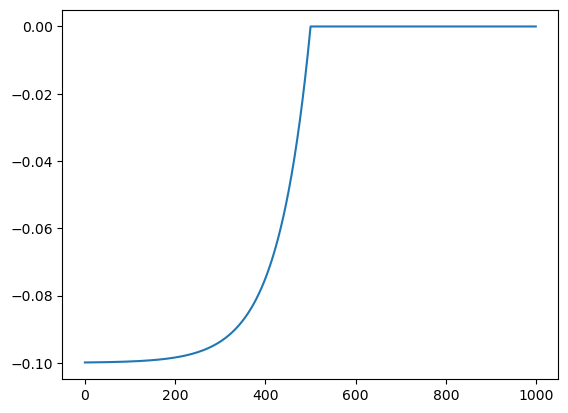

In [39]:
@njit(fastmath=True)
def delta_ps_fn(it, max_it, lambda_ps, tau_ps, delta_ps0):
    # eq. 4.15
    if it > tau_ps * max_it:
        return 0.
    else:
        return -lambda_ps + delta_ps0 * (lambda_ps / delta_ps0) ** (it / (tau_ps * max_it))
    
# demo
delta_ps0 = 1e-4
lambda_ps = 1e-1
max_it = 1000
tau_ps = 0.5

# plot of delta_ps for it: 0 -> max_it
it = np.arange(max_it)
plt.plot(it, [delta_ps_fn(i, max_it, lambda_ps, tau_ps, delta_ps0) for i in it])

In [40]:
@njit
def flood_fill(idx, S, r, k, c, stack_array, h, w, ns):
    # stack array is a preallocated array
    S[idx] = c
    stack_array[0] = idx
    get_stack, push_stack = 0, 1
    while get_stack != push_stack:
        idx = stack_array[get_stack]
        get_stack = (get_stack + 1) % ns
        for n in N_4(idx=idx, h=h, w=w):
            # NOTE: positivity ensures it is not being renumbered
            if n != -1 and S[n] >= 0:
                k_n, r, S = segmentIdWithRedirection(idx=n, S=S, r=r)
                if k_n == k:
                    S[n] = c
                    stack_array[push_stack] = n
                    push_stack = (push_stack + 1) % ns
    return S, r

# demo
dim = 8
h, w = dim, dim
ns = h * w
# random values
n_val = 5
S = np.random.randint(0, n_val, size=(ns,), dtype=np.int32)
r = np.arange(ns, dtype=np.int32)
stack_array = np.full(ns, -1, dtype=int)
k = 1
c = 10
idx = 1
print("Before:")
print(f"{S.reshape((8, 8))=}")
print("\nAfter:")
S, r = flood_fill(idx, S, r, k, c, stack_array, h, w, ns)
print(f"{S.reshape((8, 8))=}")

Before:
S.reshape((8, 8))=array([[0, 1, 3, 1, 3, 2, 4, 3],
       [1, 0, 1, 3, 0, 1, 4, 0],
       [1, 2, 2, 0, 0, 0, 0, 0],
       [3, 0, 3, 1, 1, 3, 3, 1],
       [4, 2, 1, 3, 2, 3, 4, 4],
       [4, 1, 4, 3, 0, 2, 3, 0],
       [0, 3, 2, 0, 1, 2, 2, 1],
       [4, 4, 4, 0, 3, 3, 3, 0]], dtype=int32)

After:
S.reshape((8, 8))=array([[ 0, 10,  3,  1,  3,  2,  4,  3],
       [ 1,  0,  1,  3,  0,  1,  4,  0],
       [ 1,  2,  2,  0,  0,  0,  0,  0],
       [ 3,  0,  3,  1,  1,  3,  3,  1],
       [ 4,  2,  1,  3,  2,  3,  4,  4],
       [ 4,  1,  4,  3,  0,  2,  3,  0],
       [ 0,  3,  2,  0,  1,  2,  2,  1],
       [ 4,  4,  4,  0,  3,  3,  3,  0]], dtype=int32)


In [41]:
@njit
def renumberContiguousSegment(S, r, h, w, stack_array):
    '''
    Renumber segments so they are contiguous
    '''
    c = -1
    ns = S.size
    for idx in range(ns):
        if S[idx] >= 0:
            k, r, S = segmentIdWithRedirection(idx=idx, S=S, r=r)
            S, r = flood_fill(idx=idx, S=S, r=r, k=k, c=c, stack_array=stack_array, h=h, w=w, ns=ns)
            c -= 1
    S = -S - 1
    n_used = -c - 1
    return S, n_used

# demo
dim = 8
h, w = dim, dim
ns = h * w
# random values
n_val = 4
S = np.random.randint(0, n_val, size=(ns,), dtype=np.int32)
r = np.arange(ns, dtype=np.int32)
stack_array = np.full(ns, -1, dtype=int)
print("Before:")
print(f"{S.reshape((8, 8))=}")
print("\nAfter:")
S, ns = renumberContiguousSegment(S, r, h, w, stack_array)
print(f"{S.reshape((8, 8))=}")

Before:
S.reshape((8, 8))=array([[1, 2, 3, 0, 1, 2, 0, 0],
       [0, 2, 1, 0, 3, 0, 3, 2],
       [2, 3, 2, 1, 3, 1, 1, 1],
       [0, 0, 0, 3, 3, 3, 1, 2],
       [2, 2, 2, 0, 3, 1, 0, 3],
       [1, 1, 3, 1, 0, 2, 0, 0],
       [2, 2, 3, 0, 2, 0, 3, 0],
       [0, 0, 0, 1, 3, 3, 3, 1]], dtype=int32)

After:
S.reshape((8, 8))=array([[ 0,  1,  2,  3,  4,  5,  6,  6],
       [ 7,  1,  8,  3,  9, 10, 11, 12],
       [13, 14, 15, 16,  9, 17, 17, 17],
       [18, 18, 18,  9,  9,  9, 17, 19],
       [20, 20, 20, 21,  9, 22, 23, 24],
       [25, 25, 26, 27, 28, 29, 23, 23],
       [30, 30, 26, 31, 32, 33, 34, 23],
       [35, 35, 35, 36, 34, 34, 34, 37]])


In [42]:
@njit(fastmath=True)
def updatePixelSegmentation(S, P, qk, Qk, nk, r, n_used, spawn_idxs):
    # NOTE: we recreate shorter arrays, maybe we could disregard ns and and reuse previous ones
    # though it does not seem useful (functon is called only up to n_it)
    ns = S.size
    qk *= 0
    Qk *= 0
    nk *= 0
    for k in range(n_used):
        r[k] = k
    for idx in range(ns):
        # redirection is identity at this point so not needed
        k = S[idx]
        nk[k] += 1
        qk[k] += P[idx]
        Qk[k] += P[idx] ** 2
    spawn_get_idx, spawn_add_idx = 0, ns - n_used
    for i in range(0, ns - n_used):
        spawn_idxs[i] = i + n_used
    return nk, qk, Qk, r, spawn_idxs, spawn_get_idx, spawn_add_idx

# demo
dim = 8
h, w = dim, dim
ns = h * w
n_val = 4
S = np.random.randint(0, n_val, size=(ns,), dtype=np.int32)
P = np.random.rand(ns, 3)
qk = np.zeros((n_val, 3), dtype=np.float64)
Qk = np.zeros((n_val, 3), dtype=np.float64)
nk = np.zeros(n_val, dtype=np.int32)
r = np.arange(ns, dtype=np.int32)
spawn_idxs = np.full(ns, -1, dtype=int)
updatePixelSegmentation(S, P, qk, Qk, nk, r, n_val, spawn_idxs)

(array([17, 21, 14, 12], dtype=int32),
 array([[8.7861057 , 7.81212787, 7.31083687],
        [9.54383979, 7.93239294, 7.75526946],
        [4.91253203, 8.00712479, 5.9525833 ],
        [4.88477005, 5.99136157, 5.28326799]]),
 array([[5.97299235, 4.77923775, 4.4820789 ],
        [5.7311659 , 4.38404499, 4.66441052],
        [3.50584018, 5.71118636, 3.55107824],
        [3.03259073, 3.98088408, 3.4674092 ]]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int32),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, -1, -1, -1, -1

In [43]:
def renumberSegments(S, ns):
    '''
    Renumber all pixels without imposing contiguous segments
    '''
    # NOTE: here it assumes that the redirection table is not needed, it has been flushed
    r = np.full(ns, -1, dtype=int)
    c = 0
    for idx in range(S.size):
        k = S[idx]
        if r[k] == -1:
            r[k] = c
            c += 1

    for i, j in np.ndindex(S.shape):
        k = S[i, j]
        if r[k] == -1:
            r[k] = c
            c += 1
    ns = c
    for i, j in np.ndindex(S.shape):
        S[i, j] = r[S[i, j]]
    return S, ns

In [44]:
@njit(fastmath=True)
def pixelSegmentationIteration(
    it, S, P, qk, Qk, nk, r, max_it, lambda_ps, tau_ps, delta_ps0, h, w, spawn_idxs, spawn_add_idx, spawn_get_idx, stack_array
):
    ns = S.size
    # when delta_ps is not 0, we likely can only merge
    merge_only = it < tau_ps * max_it
    n_merge, n_swap, n_spawn = 0, 0, 0
    delta_ps = delta_ps_fn(
        it=it, max_it=max_it, lambda_ps=lambda_ps, tau_ps=tau_ps, delta_ps0=delta_ps0
    )
    for idx in range(ns):
        k, r, S = segmentIdWithRedirection(idx=idx, S=S, r=r)
        for neighbor in N_4(idx=idx, h=h, w=w):
            if neighbor != -1:
                k_prime, r, S = segmentIdWithRedirection(idx=neighbor, S=S, r=r)
                
                if k != k_prime:
                    # merge k_prime into k - 0.02s
                    if (
                        psi_m(
                            qk=qk[k],
                            nk=nk[k],
                            qk_prime=qk[k_prime],
                            nk_prime=nk[k_prime],
                            lambda_ps=lambda_ps,
                        )
                        < delta_ps
                    ):
                        # eq. 4.4-4.6
                        qk[k] += qk[k_prime]
                        qk[k_prime] = 0
                        Qk[k] += Qk[k_prime]
                        Qk[k_prime] = 0
                        nk[k] += nk[k_prime]
                        nk[k_prime] = 0
                        r[k_prime] = k
                        n_merge += 1
                        # new spawn position
                        spawn_idxs[spawn_add_idx] = k_prime
                        spawn_add_idx = (spawn_add_idx + 1) % ns
                    elif not merge_only:
                        # swap - slow 0.3s
                        p_prime = P[neighbor]
                        if nk[k_prime] > 1 and psi_s(
                            qk=qk[k],
                            nk=nk[k],
                            qk_prime=qk[k_prime],
                            nk_prime=nk[k_prime],
                            pij=p_prime,
                        ) < delta_ps:
                            # eq. 4.8-4.10
                            p_prime_sq = np.square(p_prime)
                            qk[k] += p_prime
                            qk[k_prime] -= p_prime
                            Qk[k] += p_prime_sq
                            Qk[k_prime] -= p_prime_sq
                            nk[k] += 1
                            nk[k_prime] -= 1
                            S[neighbor] = k
                            n_swap += 1

        # spawn - (0.08s each)
        if not merge_only and nk[k] > 1 and spawn_get_idx != spawn_add_idx:
            p = P[idx]
            if psi_p(qk=qk[k], nk=nk[k], pij=p, lambda_ps=lambda_ps) < delta_ps:
                spawn_position = spawn_idxs[spawn_get_idx]
                spawn_get_idx = (spawn_get_idx + 1) % ns
                # eq. 4.12-4.14
                p_sq = np.square(p)
                qk[k] -= p
                Qk[k] -= p_sq
                nk[k] -= 1
                qk[spawn_position] = p
                Qk[spawn_position] = p_sq
                nk[spawn_position] = 1
                S[idx] = spawn_position
                n_spawn += 1
    if n_swap + n_spawn > 0:
        S, n_used = renumberContiguousSegment(S=S, r=r, h=h, w=w, stack_array=stack_array)
        nk, qk, Qk, r, spawn_idxs, spawn_get_idx, spawn_add_idx = updatePixelSegmentation(
            S=S, P=P, qk=qk, Qk=Qk, nk=nk, r=r, n_used=n_used, spawn_idxs=spawn_idxs
        )
    return S, qk, Qk, nk, r, n_merge, n_swap, n_spawn, spawn_idxs, spawn_add_idx, spawn_get_idx

In [45]:
# we create a little array to keep track of performance
metrics = []

In [46]:
def pixelSegmentation(
    P,  # image h*w*3, in lab space in [0, 1]
    max_it,  # max number of iterations
    lambda_ps,
    tau_ps,
    delta_ps0,
):
    # initialize variables
    h, w, c = P.shape
    assert c == 3
    P = P.reshape(-1, 3)
    S, nk, qk, Qk, r, ns, spawn_idxs = initPixelSegmentation(P)
    spawn_add_idx, spawn_get_idx = 0, 0
    stack_array = np.full(ns, -1, dtype=int)
    total_counts = {"merge": 0, "swap": 0, "spawn": 0}
    start_time = time.time()
    global_start_time = start_time

    for it in range(max_it):
        print(f"iteration {it}")
        (
            S,
            qk,
            Qk,
            nk,
            r,
            n_merge,
            n_swap,
            n_spawn,
            spawn_idxs,
            spawn_add_idx,
            spawn_get_idx,
        ) = pixelSegmentationIteration(
            it=it,
            S=S,
            P=P,
            qk=qk,
            Qk=Qk,
            nk=nk,
            r=r,
            max_it=max_it,
            lambda_ps=lambda_ps,
            tau_ps=tau_ps,
            delta_ps0=delta_ps0,
            h=h,
            w=w,
            spawn_idxs=spawn_idxs,
            spawn_add_idx=spawn_add_idx,
            spawn_get_idx=spawn_get_idx,
            stack_array=stack_array,
        )
        print(f"{n_merge=} {n_swap=} {n_spawn=}")
        delta_ps_null = it < tau_ps * max_it

        total_counts["merge"] += n_merge
        total_counts["swap"] += n_swap
        total_counts["spawn"] += n_spawn
        end_time = time.time()
        print(f"Time: {end_time - start_time:.2f}s")
        start_time = end_time

        if delta_ps_null and n_merge + n_swap + n_spawn == 0:
            print("Early stopping")
            break

    n_segments = np.unique(S).size
    print("Total counts:\n", total_counts)
    print("Unique segments:", n_segments)
    print("Total time:", time.time() - global_start_time)
    metrics.append(
        {
            "time": time.time() - global_start_time,
            "segments": n_segments,
            "max_it": max_it,
            "lambda_ps": lambda_ps,
            "tau_ps": tau_ps,
            "delta_ps0": delta_ps0,
            "merge": total_counts["merge"],
            "swap": total_counts["swap"],
            "spawn": total_counts["spawn"],
        }
    )
    # renumber segments
    S, n_used = renumberContiguousSegment(S=S, r=r, h=h, w=w, stack_array=stack_array)
    
    return S, n_used



# demo
# NOTE: fig 2.2 is a simple image and seems to be slightly above 512x512
max_it = 20  # figure 4.2 mentions 50 iterations but in our case 20 may be enough
lambda_ps = 1e-1  # 4.2.3 mentions range from 1e-2 to 1e1, depending on noise and required complexity
tau_ps = 0.5  # not defined anywhere
delta_ps0 = 1e-4  # 4.2.3 suggests 1e-4
print("Shape:", img_np.shape)
S, n_used = pixelSegmentation(
    P=img_np, max_it=max_it, lambda_ps=lambda_ps, tau_ps=tau_ps, delta_ps0=delta_ps0
)

Shape: (512, 512, 3)
iteration 0
n_merge=254169 n_swap=0 n_spawn=0
Time: 1.65s
iteration 1
n_merge=267 n_swap=0 n_spawn=0
Time: 0.03s
iteration 2
n_merge=596 n_swap=0 n_spawn=0
Time: 0.03s
iteration 3
n_merge=803 n_swap=0 n_spawn=0
Time: 0.03s
iteration 4
n_merge=747 n_swap=0 n_spawn=0
Time: 0.03s
iteration 5
n_merge=934 n_swap=0 n_spawn=0
Time: 0.03s
iteration 6
n_merge=860 n_swap=0 n_spawn=0
Time: 0.03s
iteration 7
n_merge=1063 n_swap=0 n_spawn=0
Time: 0.03s
iteration 8
n_merge=880 n_swap=0 n_spawn=0
Time: 0.03s
iteration 9
n_merge=639 n_swap=0 n_spawn=0
Time: 0.03s
iteration 10
n_merge=535 n_swap=926 n_spawn=0
Time: 0.11s
iteration 11
n_merge=61 n_swap=149 n_spawn=0
Time: 0.11s
iteration 12
n_merge=9 n_swap=33 n_spawn=0
Time: 0.11s
iteration 13
n_merge=3 n_swap=12 n_spawn=0
Time: 0.11s
iteration 14
n_merge=2 n_swap=7 n_spawn=0
Time: 0.11s
iteration 15
n_merge=3 n_swap=7 n_spawn=0
Time: 0.11s
iteration 16
n_merge=2 n_swap=6 n_spawn=0
Time: 0.11s
iteration 17
n_merge=3 n_swap=6 n_spaw

In [47]:
# NOTE:
# you can run above cell a few times with different parameters
# the first time a numba function is called, it is compiled and takes a bit of extra time
pd.DataFrame(metrics)

,time,segments,max_it,lambda_ps,tau_ps,delta_ps0,merge,swap,spawn
0,3.067543,609,20,0.1,0.5,0.0001,261581,1156,0


In [48]:
# S is currently flat
S.shape

(262144,)

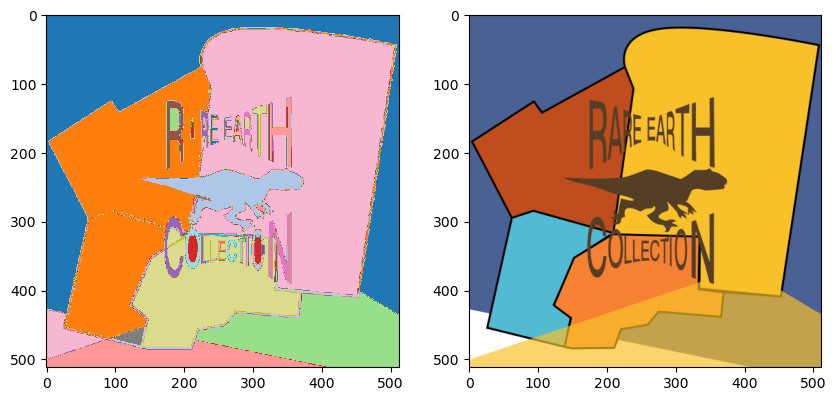

In [49]:
# visualize segmentation vs original image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(S.reshape(512, 512) % 20, cmap="tab20")
ax[1].imshow(cv2.cvtColor(img_resized, cv2.COLOR_LAB2RGB))

### Anti-alias

#### Method 1: scipy.minimize

In [50]:
def _findWeightsN(C, p):
    # find weights of each color from C to get close to p
    # NOTE: should be used with N>=3, otherwise more simple method can be used

    constraints = [{"type": "eq", "fun": lambda weights: np.sum(weights) - 1}]
    n_points = C.shape[1]
    bounds = [(0, 1)] * n_points
    initial_guess = np.ones(n_points) / n_points

    def objective(weights):
        delta = p - C @ weights
        return np.dot(delta, delta)

    # define jacobian
    def jac(weights):
        return -2 * C.T @ (p - C @ weights)

    res = minimize(
        objective,
        initial_guess,
        bounds=bounds,
        constraints=constraints,
        jac=jac,   # should be just a bit faster (and more accurate) with jacobian with >3 points but not needed here
        options={
            "maxiter": 5,  # 5 -> almost same as 100, 3 -> pretty close
        },
    )
    return res.x


def check_objective(weights, C, p):
    delta = p - C @ weights
    return np.dot(delta, delta)


# demo
c1 = np.array([0.0, 0.4, 0.0])
c2 = np.array([1.0, 1.0, 1.0])
c3 = np.array([0.5, 0.4, 0.0])
C = np.array([c1, c2, c3]).T

p = 0.7 * c1 + 0.1 * c2 + 0.2 * c3

_findWeightsN(C, p), w
#check_objective(w, C, p)

(array([0.69640813, 0.10111303, 0.20247885]), 8)

In [51]:
%%timeit

_findWeightsN(C, p)

581 μs ± 2.13 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [52]:
metrics = []
for _ in tqdm(range(1000)):
    # random colors between 0 and 1
    n_colors = 3
    C = np.random.rand(3, n_colors)
    w = np.random.rand(n_colors)
    w /= w.sum(axis=-1)
    noise = np.random.rand(3) * 0.03
    p = C @ w + noise
    try:
        w_pred = _findWeightsN(C, p)
        max_w_correct = np.argmax(w_pred) == np.argmax(w)
        error = np.linalg.norm(w_pred - w)
    except Exception as e:
        print(e)
        w_pred = None
        max_w_correct = False
        error = np.inf

    # metrics
    metrics.append({"max_w_correct": max_w_correct, "error": error})

100%|██████████| 1000/1000 [00:00<00:00, 1688.22it/s]


In [53]:
df = pd.DataFrame(metrics)
df

,max_w_correct,error
0,True,0.058990
1,True,0.269949
2,False,0.077308
3,False,0.058713
4,True,0.099068
...,...,...
995,True,0.045755
996,True,0.013590
997,True,0.048333
998,True,0.161033


In [54]:
df.max_w_correct.value_counts()

max_w_correct
True     841
False    159
Name: count, dtype: int64

#### Method 2: closest point

In [55]:
@njit
def _closest_point(C, p):
    sq_dist = np.sum((C - p[:, None]) ** 2, axis=0)
    weights = sq_dist.clip(1e-10, 1e10)
    weights = 1 / sq_dist
    weights /= weights.sum()
    return weights

# demo
n_points = 3
C = np.random.rand(3, n_points)
true_w = np.random.rand(n_points)
true_w /= true_w.sum()
p = C @ true_w

true_w, _closest_point(C, p)

(array([0.34737759, 0.35521948, 0.29740294]),
 array([0.14794833, 0.27654152, 0.57551015]))

In [56]:
%%timeit

_closest_point(C, p)

1.06 μs ± 3.25 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [57]:
metrics = []
for _ in tqdm(range(10000)):
    # random colors between 0 and 1
    n_colors = 3
    C = np.random.rand(3, n_colors)
    w = np.random.rand(n_colors)
    w /= w.sum(axis=-1)
    noise = np.random.rand(3) * 0.03
    p = C @ w + noise
    try:
        w_pred = _closest_point(C, p)
        max_w_correct = np.argmax(w_pred) == np.argmax(w)
        error = np.linalg.norm(w_pred - w)
    except Exception as e:
        print(e)
        w_pred = None
        max_w_correct = False
        error = np.inf

    # metrics
    metrics.append({"max_w_correct": max_w_correct, "error": error})

100%|██████████| 10000/10000 [00:00<00:00, 101673.44it/s]


In [58]:
df = pd.DataFrame(metrics)
df.max_w_correct.value_counts()

max_w_correct
True     6510
False    3490
Name: count, dtype: int64

#### Method 2: Cholesky

In [59]:
@njit#(nf64(nf64, nf64))
def non_zero(val, eps=1e-5):
    return val if val else eps

#@njit(nf64[:, :](nf64[:, :]), fastmath=True)
@njit(nf64[:, :](nf64[:, :]))
def cho_factor(A):
    n = A.shape[0]
    U = np.zeros_like(A, dtype=np.float64)

    for i in range(n):
        for j in range(i, n):
            sum_val = np.dot(U[:i, j], U[:i, i])
            if i == j:
                U[i, j] = np.sqrt(A[i, i] - sum_val)
            else:
                U[i, j] = (A[i, j] - sum_val) / non_zero(U[i, i])
    return U


#@njit(nf64[:](nf64[:, :], nf64[:]), fastmath=True)
@njit(nf64[:](nf64[:, :], nf64[:]))
def forward_substitution(U, b):
    """Solve the equation U^T * y = b for y. U is upper triangular."""
    n = U.shape[0]
    y = np.zeros((n,), dtype=np.float64)
    for i in range(n):
        sum_val = 0.0
        for j in range(i):
            sum_val += U[j][i] * y[j]
        y[i] = (b[i] - sum_val) / non_zero(U[i, i])
    return y


#@njit(nf64[:](nf64[:, :], nf64[:]), fastmath=True)
@njit(nf64[:](nf64[:, :], nf64[:]))
def backward_substitution(U, y):
    """Solve the equation U * x = y for x. U is upper triangular."""
    n = U.shape[0]
    x = np.zeros((n,), dtype=np.float64)
    for i in range(n - 1, -1, -1):
        sum_val = 0
        for j in range(i + 1, n):
            sum_val += U[i][j] * x[j]
        x[i] = (y[i] - sum_val) / non_zero(U[i, i])
    return x


#@njit(nf64[:](nf64[:, :], nf64[:]), fastmath=True)
@njit(nf64[:](nf64[:, :], nf64[:]))
def cho_solve_v(U, b):
    # Solve U^T * y = b
    y = forward_substitution(U, b)

    # Solve U * x = y
    x = backward_substitution(U, y)
    return x


#@njit(nf64[:, :](nf64[:, :], nf64[:], nf64[:, :]), fastmath=True)
@njit(nf64[:, :](nf64[:, :], nf64[:], nf64[:, :]))
def cho_solve(U, b, X):
    vector = cho_solve_v(U, b)
    X = np.column_stack((X, vector))
    return X

/var/folders/7y/83_06m8j4wl2__6twbncyql40000gn/T/ipykernel_12954/44911985.py:13: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  sum_val = np.dot(U[:i, j], U[:i, i])


In [60]:
#@njit(fastmath=True)
@njit
def _findWeightsCholesky(C, p, epsilon=1e-4):
    n = C.shape[1]
    m = 1
    A = np.dot(C.T, C) + epsilon * np.eye(n)
    b = np.dot(C.T, p)
    UA = cho_factor(A)
    B = np.ones((n, m), dtype=np.float64)  # For the equality constraint
    c = np.ones((1), dtype=np.float64)
    D = cho_solve_v(UA, B[:, -1])[:, None]

    while True:
        S = np.dot(B.T, D)
        f = c - np.dot(D.T, b)
        US = cho_factor(S)
        v = cho_solve_v(US, f)
        w = cho_solve_v(UA, b - np.dot(B, v))
        if np.min(w) >= 0 or m >= n + 1:
            break
        i = np.argmin(w)
        B = np.hstack((B, np.eye(n)[:, i : i + 1]))
        c = np.concatenate((c, np.zeros(1)))
        m += 1
        D = cho_solve(UA, B[:, -1], D)
    return w #, m  # for metrics calc


# Demo
w, _findWeightsCholesky(C, p, epsilon=1e-2)

/var/folders/7y/83_06m8j4wl2__6twbncyql40000gn/T/ipykernel_12954/3982972109.py:14: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  S = np.dot(B.T, D)
/var/folders/7y/83_06m8j4wl2__6twbncyql40000gn/T/ipykernel_12954/3982972109.py:15: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  f = c - np.dot(D.T, b)
/var/folders/7y/83_06m8j4wl2__6twbncyql40000gn/T/ipykernel_12954/3982972109.py:18: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  w = cho_solve_v(UA, b - np.dot(B, v))


(array([0.42580277, 0.19394255, 0.38025468]),
 array([0.42778617, 0.22533257, 0.40139293]))

In [61]:
_findWeightsCholesky(C, p, epsilon=0*1e-2)

array([0.54954415, 0.05463454, 0.47240968])

In [62]:
%%timeit

_findWeightsCholesky(C, p)

The slowest run took 7.36 times longer than the fastest. This could mean that an intermediate result is being cached.
6.42 μs ± 7.04 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
if False:
    # for test only, uncomment return of function to return m as well
    epsilon_options = [0]
    #epsilon_options = [0, 1e-6, 1e-4, 1e-2]

    for epsilon in epsilon_options:
        metrics = []
        for _ in tqdm(range(10_000)):
            # random colors between 0 and 1
            n_colors = 3
            C = np.random.rand(3, n_colors)
            w = np.random.rand(n_colors)
            w /= w.sum(axis=-1)
            noise = np.random.rand(3) * 0.01
            p = C @ w + noise
            try:
                w_pred, m = _findWeightsCholesky(C, p, epsilon=epsilon)
                max_w_correct = np.argmax(w_pred) == np.argmax(w)
                error = np.linalg.norm(w_pred - w)
                #assert w_pred.min() >= 0, w_pred
            except Exception as e:
                #raise e
                print(e)
                w_pred = None
                m = 0
                max_w_correct = False
                error = np.inf

            # metrics
            metrics.append({"max_w_correct": max_w_correct, "error": error, "m": m})

        df = pd.DataFrame(metrics)
        print(f"epsilon: {epsilon}")
        res = df.max_w_correct.value_counts()
        print(res)

In [64]:
#print(df)

In [65]:
# errors
#len(df[df.m==0])

In [66]:
#df[df.m>1].max_w_correct.value_counts()

In [67]:
#df[df.m==1].max_w_correct.value_counts()

In [68]:
#df[df.m>1]

#### Combining cholesky + points distance for failures

In [69]:
@njit
def findWeightsN(C, p):
    w = _findWeightsCholesky(C, p, epsilon=0)
    if w.min() < 0 or w.max() > 1e10 or w.sum() == 0:
        return _closest_point(C, p)
    else:
        return w / w.sum()

findWeightsN(C, p)

array([0.51044964, 0.05074784, 0.43880251])

In [70]:
%%timeit

findWeightsN(C, p)

3.13 μs ± 51 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [71]:
metrics = []
for _ in tqdm(range(1_000)):
    # random colors between 0 and 1
    n_colors = 3
    C = np.random.rand(3, n_colors)
    w = np.random.rand(n_colors)
    w /= w.sum(axis=-1)
    noise = np.random.rand(3) * 0.03
    p = C @ w + noise
    try:
        w_pred = findWeightsN(C, p)
        max_w_correct = np.argmax(w_pred) == np.argmax(w)
        error = np.linalg.norm(w_pred - w)
        assert np.abs(w.sum() - 1) < 1e-3, "Sum not 1"
        assert w.min() >= 0, "Negative value"
        assert w.max() <= 1, "Value above 1"
    except Exception as e:
        print(e)
        w_pred = None
        max_w_correct = False
        error = np.inf

    # metrics
    metrics.append({"max_w_correct": max_w_correct, "error": error})

df = pd.DataFrame(metrics)

100%|██████████| 1000/1000 [00:00<00:00, 38951.56it/s]


In [72]:
df

,max_w_correct,error
0,True,0.038970
1,True,0.100733
2,True,0.042587
3,True,0.019455
4,True,0.006553
...,...,...
995,True,0.112327
996,False,0.040437
997,True,0.031584
998,True,0.042029


In [73]:
df.max_w_correct.value_counts()

max_w_correct
True     779
False    221
Name: count, dtype: int64

<Axes: >

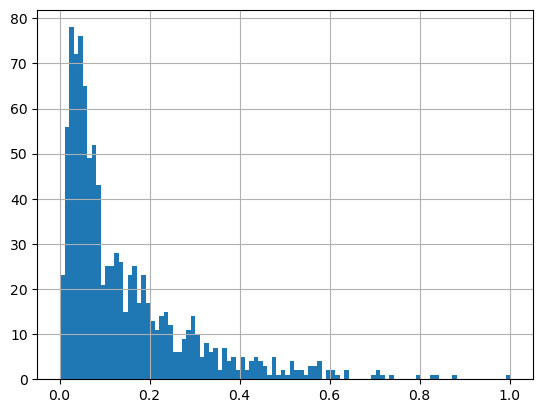

In [74]:
# show error distribution
df.error.hist(bins=100)

#### Method 3: Gradient descent

Not great:
* gradients lead through negative numbers sometimes
* hard to define step size and number of steps

In [75]:
@njit(fastmath=True)
def solve_linear_combination(vectors, target):
    num_vectors = vectors.shape[0]
    weights = np.ones(num_vectors, dtype=np.float64) / num_vectors  # Initialize weights equally
    step_size = 1.e-2  # Learning rate
    num_steps = 100  # Number of steps for the approximation

    for _ in range(num_steps):
        # Compute the current approximation
        current_approximation = np.dot(weights, vectors) / np.sum(weights)
        error = current_approximation - target

        # Compute the gradient of the loss function
        weights_gradient = - 2 * np.dot(vectors.T, error)
        # multilpy by (1 - w) - more accurate to consider weight norm in gradient
        weights_gradient *= (1 - weights)
        
        weights -= step_size * weights_gradient
        #print(weights)

        # Enforce the constraints (weights between 0 and 1, sum to 1)
        #weights = np.clip(weights, 0., 1.)
        #weights /= np.sum(weights)
        #print(weights)
        
    return weights

# Define three vectors
v1 = np.array([1, 2, 3])
v2 = np.array([4, 5, 6])
v3 = np.array([7, 8, 9])

# Combine vectors into a matrix
vectors = np.array([v1, v2, v3]) * 1.

# Define target vector
target = 0.2 * v1 + 0.3 * v2 + 0.5 * v3

c1 = np.array([0.0, 0.0, 0.0])
c2 = np.array([1.0, 1.0, 1.0])
c3 = np.array([0.5, 0.4, 0.0])
C = np.array([c1, c2, c3]).T

p = 0.7 * c1 + 0.1 * c2 + 0.2 * c3
vectors = C.T
target = p

# Solve for weights
weights = solve_linear_combination(vectors, target)
print("Weights:", weights)

# Verify the result
approximation = np.dot(weights, vectors)
print("Approximation:", approximation)
print("Target:", target)

Weights: [0.70467335 0.69005564 0.62407006]
Approximation: [1.00209066 0.93968366 0.69005564]
Target: [0.2  0.18 0.1 ]


In [76]:
%%timeit

solve_linear_combination(vectors, target)

41.5 μs ± 457 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Special case: 2 points

In [77]:
@njit
def findWeights2(C, p):
    # same as findWeightsN but with 2 colors
    EPS = 1e-4
    delta_c = C[1] - C[0]
    delta_c_sq = np.dot(delta_c, delta_c)
    t = np.dot(p - C[0], delta_c) / delta_c_sq
    delta_t = EPS * (1 - 2 * t) / (2 * EPS + delta_c_sq)
    res = 1 - t - delta_t
    # clip
    return np.array([res, 1 - res]).clip(0., 1.)

# demo
C = np.array([[0.0, 0.0, 0], [0.7, 1.0, 0]])
p = 0.7 * C[0] + 0.3 * C[1]
findWeights2(C, p)

array([0.69997316, 0.30002684])

In [78]:
%%timeit

findWeights2(C, p)

808 ns ± 6.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [79]:
@njit
def findWeights(C, p):
    if len(C) == 2:
        return findWeights2(C, p)
    else:
        return findWeightsN(C, p)

In [80]:
findWeights(C, p)

array([0.69997316, 0.30002684])

#### Apply anti-alias

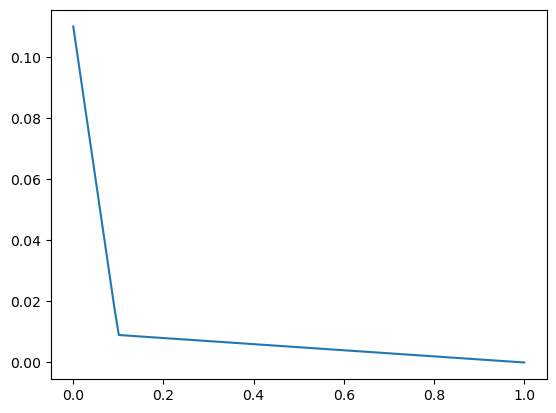

In [81]:
@njit
def fsw(w):
    # e.q. 4.27, self-weight penalty for sub-pixel segmentation
    return 1e-2 * (1 - w) + max(0, (1e-1 - w))

# demo
n_int = 100
w_lin = np.linspace(0, 1, n_int)
plt.plot(w_lin, [fsw(w) for w in w_lin])

In [82]:
%%timeit

fsw(0.5)

86 ns ± 0.282 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [83]:
@njit
def median(x):
    # np.median is not supported by numba when using an axis
    bs, channels = x.shape
    res = np.zeros(channels, dtype=x.dtype)
    for c in range(channels):
        res[c] = np.median(x[:, c])
    return res

In [84]:
@njit(fastmath=True)
def rebuildSegmentData(
        S,  # segmentation map of shape (w*h,), has been renumbered
        P,  # image of shape (w*h*3,)
        n_used,  # number of segments used
        ):
    # init variables
    h, w, c = P.shape
    assert c == 3
    P = P.reshape(-1, 3)
    assert P.shape[0] == S.shape[0]
    ns = S.size
    Bk = []  # list of set supported by numba but not dict of set
    Sk = []  # used to quickly find pixels within a segment
    fake_int = int(5)
    # add a fake element for numba type inference
    for k in range(n_used):
        sb = {fake_int}
        ss = {fake_int}
        sb.pop()
        ss.pop()
        Bk.append(sb)
        Sk.append(sb)
    nk = np.zeros(n_used, dtype=np.int_)
    qk = np.zeros((n_used, 3), dtype=P.dtype)
    Qk = np.zeros((n_used, 3), dtype=P.dtype)
    uk = np.zeros((n_used, 3), dtype=P.dtype) 

    for idx in range(ns):
        k = S[idx]
        Sk[k].add(idx)
        b = False
        for n in N_8(idx=idx, h=h, w=w):
            if n != -1:
                k_prime = S[n]
                if k != k_prime:
                    Bk[k].add(idx)
                    Bk[k_prime].add(idx)
                    b = True
        if not b:
            nk[k] += 1
            qk[k] += P[idx]
            Qk[k] += P[idx] ** 2


    for k in range(n_used):

        if nk[k] > 3:
            uk[k] = qk[k] / nk[k]
        else:
            # get median
            idxs = np.array(list(Sk[k]))
            uk[k] = median(P[idxs])
    return Bk, nk, qk, Qk, uk

res = rebuildSegmentData(S=S, P=img_np, n_used=n_used)

In [85]:
%%timeit

rebuildSegmentData(S=S, P=img_np, n_used=n_used)

71.6 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
def fic(uk, nk, qk, h, w):
    # e.q. 4.29
    return np.sum((uk - qk / nk) ** 2)

def fbc(S, uk, Bk, P):
    # e.q. 4.30
    total = 0
    for idx in Bk:
        neighbors = N_8(idx=idx, h=h, w=w)
        segments = set(S[idx])  # for self weight
        # first element is self weight
        l_segments = [S[idx]]
        for n in neighbors:
            if n != -1 and S[n] not in segments:
                segments.add(S[n])  # TODO: may need to use redirection table
                l_segments.append(S[n])
        # create color list
        colors = np.zeros((3, len(l_segments)), dtype=P.dtype)
        for i, k in enumerate(l_segments):
            colors[:, i] = uk[k]
        # find weights
        weights = findWeights(colors, P[idx])
        # calculate error
        error = colors @ weights - P[idx]
        total += np.dot(error, error) + fsw(weights[0])
    return total

In [87]:
def considerMerge(S):


SyntaxError: incomplete input (1612793566.py, line 1)

In [ ]:
# export to script
!jupyter nbconvert --to script dev.ipynb